In [2]:

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import scipy
from scipy.cluster import hierarchy
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import classification_report, roc_auc_score, fbeta_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns



In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
def specificity_score(y_true, y_predict):
    TN = 0  # True Negative
    FP = 0  # False Positive
    for true, pred in zip(y_true, y_predict):
        if true == 0:
            if pred == 0:
                TN += 1
            else:  
                FP += 1
    
    if TN + FP == 0:
        return 0.0
    
    return TN / (TN + FP)
def precision_recall_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    
    # --- main
    targets, probas = sort_pair(targets, probas)
    precision, recall, thresholds = metrics.precision_recall_curve(targets, probas)
    
    # calculate precision-recall AUC
    auc_val = metrics.auc(recall, precision)
    print('Area Under Curve (AUC) : {:.3f}'.format(auc_val))
    # plot no skill
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) # thresholds are sorted

        print('Recall with threshold = {}: {:.2f}%'.format(threshold, recall[index]*100))
        print('Precision with threshold = {} : {:.2f}%'.format(threshold, precision[index]*100))

        plt.plot([0, 1], [precision[index], precision[index]], linestyle='--', color = 'grey')
        plt.plot([recall[index], recall[index]], [0, 1], linestyle='--', color = 'grey')
        
        # plot the precision-recall curve for the model
        plt.plot(recall[:index], precision[:index], color = 'navy', marker='.')
        plt.plot(recall[index:], precision[index:], color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve with threshold = {}'.format(threshold))
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        # plot the precision-recall curve for the model
        plt.plot(recall, precision, color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

In [4]:
df = pd.read_csv('heart_2022_with_nans.csv', low_memory=False)
df_clean = df.dropna(subset=['HadHeartAttack']).copy()
df_clean['HadHeartAttack'] = df_clean['HadHeartAttack'].map({'Yes': 1, 'No': 0})
df_clean['HadHeartAttack'].value_counts()
display_all(df_clean.head().T)

,0,1,2,3,4
State,Alabama,Alabama,Alabama,Alabama,Alabama
Sex,Female,Female,Female,Female,Female
GeneralHealth,Very good,Excellent,Very good,Excellent,Fair
PhysicalHealthDays,0.0,0.0,2.0,0.0,2.0
MentalHealthDays,0.0,0.0,3.0,0.0,0.0
LastCheckupTime,Within past year (anytime less than 12 months ...,NaN,Within past year (anytime less than 12 months ...,Within past year (anytime less than 12 months ...,Within past year (anytime less than 12 months ...
PhysicalActivities,No,No,Yes,Yes,Yes
SleepHours,8.0,6.0,5.0,7.0,9.0
RemovedTeeth,NaN,NaN,NaN,NaN,NaN
HadHeartAttack,0,0,0,0,0


In [5]:
target_col = 'HadHeartAttack'
df=df.dropna(subset=[target_col])
df[target_col] = df[target_col].map({'Yes': 1, 'No': 0}).astype(int)
print(f"size: {len(df)}")
print(f"Distribution: \n{df[target_col].value_counts()}")

size: 442067
Distribution: 
HadHeartAttack
0    416959
1     25108
Name: count, dtype: int64


In [6]:
ordinal_cols = {
    'GeneralHealth': ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],
    'LastCheckupTime': ['Within past year (anytime less than 12 months ago)', 'Within past 2 years (1 year but less than 2 years ago)', 'Within past 5 years (2 years but less than 5 years ago)', '5 or more years ago'],
    'RemovedTeeth': ['None of them', '1 to 5', '6 or more, but not all', 'All'],
    'HadDiabetes': ['No', 'No, pre-diabetes or borderline diabetes', 'Yes, but only during pregnancy (female)', 'Yes'],
    'SmokerStatus': ['Never smoked', 'Former smoker', 'Current smoker - now smokes some days', 'Current smoker - now smokes every day'],
    'ECigaretteUsage': ['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day'],
    'AgeCategory': sorted(df['AgeCategory'].dropna().unique()), 
    'TetanusLast10Tdap': ['No, did not receive any tetanus shot in the past 10 years', 'Yes, received tetanus shot, but not Tdap', 'Yes, received tetanus shot but not sure what type', 'Yes, received Tdap'],
    'CovidPos': ['No', 'Tested positive using home test without a health professional', 'Yes']
}

for col, order in ordinal_cols.items():
    if col in df.columns:
        df[col] = pd.Categorical(df[col], categories=order, ordered=True)
        df[col] = df[col].cat.codes

In [7]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
remain_cat_cols = [c for c in df.columns if c not in num_cols]

print(f" One-Hot For The following col : {remain_cat_cols}")
df_processed = pd.get_dummies(df, columns=remain_cat_cols, drop_first=True, dummy_na=True)

X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"train set size: {X_train.shape}")
print(f"validation set size: {X_valid.shape}")
median=X_train.median(numeric_only=True)
df_processed = df_processed.fillna(median)

 One-Hot For The following col : ['State', 'Sex', 'PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'RaceEthnicityCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear']
train set size: (353653, 118)
validation set size: (88414, 118)


In [8]:

X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"train set size: {X_train.shape}")
print(f"validation set size: {X_valid.shape}")

train set size: (353653, 118)
validation set size: (88414, 118)


In [9]:

rf_model = RandomForestClassifier(
    n_estimators=200,      
    max_depth=15,           
    min_samples_leaf=10,    
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
y_prob = rf_model.predict_proba(X_valid)[:, 1]

y_pred_default = rf_model.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_default))

ROC-AUC Score: 0.8865

Default threshold (0.5) classification:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     83392
           1       0.24      0.73      0.36      5022

    accuracy                           0.86     88414
   macro avg       0.61      0.80      0.64     88414
weighted avg       0.94      0.86      0.89     88414



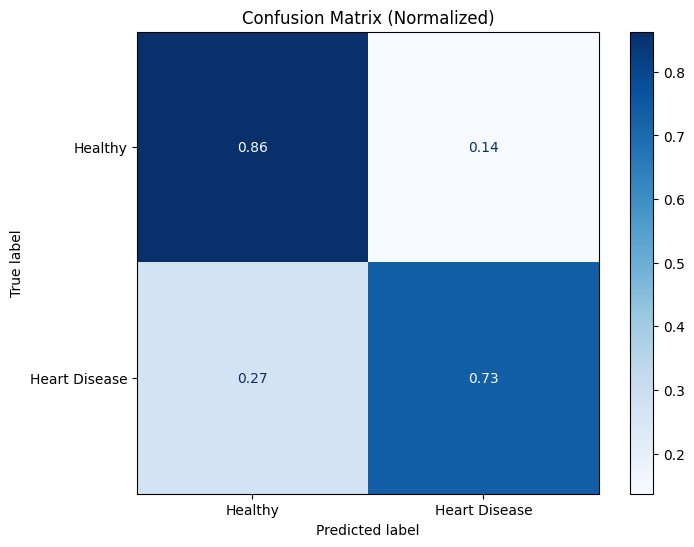

In [11]:

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_valid, 
    y_pred_default,
    display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues',
    normalize='true', 
    ax=ax
)
plt.title("Confusion Matrix (Normalized)")
plt.show()




In [12]:
thresholds = [0.1,0.2,0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_pred_adjusted = (y_prob >= threshold).astype(int)
    rec = metrics.recall_score(y_valid, y_pred_adjusted)
    prc = metrics.precision_score(y_valid, y_pred_adjusted)
    f1 =metrics.f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold {threshold}: Recall={rec:.3f}, Precision={prc:.3f}", f", F1-Score={f1:.3f}")

Threshold 0.1: Recall=0.992, Precision=0.073 , F1-Score=0.136
Threshold 0.2: Recall=0.963, Precision=0.100 , F1-Score=0.181
Threshold 0.3: Recall=0.911, Precision=0.131 , F1-Score=0.229
Threshold 0.4: Recall=0.834, Precision=0.175 , F1-Score=0.290
Threshold 0.5: Recall=0.731, Precision=0.243 , F1-Score=0.365
Threshold 0.6: Recall=0.617, Precision=0.344 , F1-Score=0.442


In [13]:
best_th = 0.5
best_score = 0

for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_prob >= th).astype(int)
    score = fbeta_score(y_valid, y_pred_temp, beta=2) 
    if score > best_score:
        best_score = score
        best_th = th

print(f"Best threshold: {best_th:.2f} (F2-Score: {best_score:.4f})")
print(classification_report(y_valid, (y_prob >= best_th).astype(int)))

Best threshold: 0.55 (F2-Score: 0.5345)
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     83392
           1       0.29      0.68      0.41      5022

    accuracy                           0.89     88414
   macro avg       0.63      0.79      0.67     88414
weighted avg       0.94      0.89      0.91     88414



In [14]:
calibrated_classifier = CalibratedClassifierCV(
    estimator = rf_model,
    method = 'sigmoid',
    ensemble = True,
    cv = 3,
    n_jobs = -1,
)

In [15]:
calibrated_classifier.fit(X_train, y_train)
print(calibrated_classifier.score(X_valid, y_valid))

0.9461397516230461


In [16]:
y_predict_valid2 = calibrated_classifier.predict(X_valid)

acc2 = metrics.accuracy_score(y_valid, y_predict_valid2)
rec2 = metrics.recall_score(y_valid, y_predict_valid2)
prc2 = metrics.precision_score(y_valid, y_predict_valid2)
f1_2 = metrics.f1_score(y_valid, y_predict_valid2)

print('Accuracy : {:.2f}%'.format(acc2*100))
print('Recall : {:.2f}%'.format(rec2*100))
print('Precision : {:.2f}%'.format(prc2*100))

Accuracy : 94.61%
Recall : 21.43%
Precision : 56.87%


In [17]:
y_pred_proba2 =calibrated_classifier.predict_proba(X_valid)[:, 1]
thresholds2 = [0.1,0.2,0.3, 0.4, 0.5, 0.6]
for threshold in thresholds2:
    y_pred_adjusted2 = (y_pred_proba2 >= threshold).astype(int)
    rec3 = metrics.recall_score(y_valid, y_pred_adjusted2)
    prc3 = metrics.precision_score(y_valid, y_pred_adjusted2)
    
    print(f"Threshold {threshold}: Recall={rec3:.3f}, Precision={prc3:.3f}")

Threshold 0.1: Recall=0.697, Precision=0.278
Threshold 0.2: Recall=0.554, Precision=0.402
Threshold 0.3: Recall=0.462, Precision=0.466
Threshold 0.4: Recall=0.353, Precision=0.507
Threshold 0.5: Recall=0.214, Precision=0.569
Threshold 0.6: Recall=0.051, Precision=0.708


## Catboost


In [18]:
CatBoost=CatBoostClassifier(
    iterations=1500,
    depth=6,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    l2_leaf_reg=3,
    boosting_type='Ordered',
    subsample=0.8,
    early_stopping_rounds=200,
    verbose=100,
    eval_metric='Recall',
    loss_function='Logloss',
    random_seed=42,
    use_best_model=True)
CatBoost.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[])

0:	learn: 0.7573932	test: 0.7570689	best: 0.7570689 (0)	total: 125ms	remaining: 3m 6s
100:	learn: 0.7823857	test: 0.7729988	best: 0.7737953 (92)	total: 6.37s	remaining: 1m 28s
200:	learn: 0.7885592	test: 0.7773795	best: 0.7775787 (176)	total: 12.5s	remaining: 1m 20s
300:	learn: 0.7897043	test: 0.7775787	best: 0.7781760 (248)	total: 18s	remaining: 1m 11s
400:	learn: 0.7897043	test: 0.7781760	best: 0.7783751 (338)	total: 22.6s	remaining: 1m 1s
500:	learn: 0.7894553	test: 0.7777778	best: 0.7783751 (338)	total: 27.5s	remaining: 54.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7783751493
bestIteration = 338

Shrink model to first 339 iterations.


In [19]:
y_prob_catboost = CatBoost.predict_proba(X_valid)[:, 1]

y_pred_catboost = CatBoost.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_catboost))

ROC-AUC Score: 0.8865

Default threshold (0.5) classification:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     83392
           1       0.22      0.78      0.34      5022

    accuracy                           0.83     88414
   macro avg       0.60      0.80      0.62     88414
weighted avg       0.94      0.83      0.87     88414



In [20]:
best_score_catboost=0
for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp_catboost = (y_prob_catboost >= th).astype(int)
    score_catboost = fbeta_score(y_valid, y_pred_temp_catboost, beta=2) 
    if score_catboost > best_score_catboost:
        best_score_catboost = score_catboost
        best_th = th

print(f"Best threshold: {best_th:.2f} (F2-Score: {best_score_catboost:.4f})")
print(classification_report(y_valid, (y_prob_catboost >= best_th).astype(int)))

Best threshold: 0.70 (F2-Score: 0.5404)
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     83392
           1       0.35      0.63      0.45      5022

    accuracy                           0.91     88414
   macro avg       0.66      0.78      0.70     88414
weighted avg       0.94      0.91      0.92     88414



## XGBoost Model 

In [21]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgboost = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  
    eval_metric='aucpr',                
    n_jobs=-1,
    random_state=42,
    tree_method='hist'                  
)

print("开始训练模型...")
xgboost.fit(X_train, y_train)

开始训练模型...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [22]:
y_pred_proba_xgboost = xgboost.predict_proba(X_valid)[:, 1]

roc_xgboost = roc_auc_score(y_valid, y_pred_proba_xgboost)
print(f"ROC-AUC Score: {roc_xgboost:.4f}")

precision_xg, recall_xg, thresholds_xg = precision_recall_curve(y_valid, y_pred_proba_xgboost)
pr_auc_xg = metrics.auc(recall_xg, precision_xg)
print(f"PR-AUC Score: {pr_auc_xg:.4f}")

f2_scores_xgboost = [fbeta_score(y_valid, (y_pred_proba_xgboost >= t).astype(int), beta=2) for t in thresholds]
best_idx_xg = np.argmax(f2_scores_xgboost)
best_threshold_xg = thresholds[best_idx_xg]
best_f2_xg = f2_scores_xgboost[best_idx_xg]

print(f"\nBest threshold: {best_threshold_xg:.3f}")
print(f" F2-Score: {best_f2_xg:.4f}")

y_pred_optimal = (y_pred_proba_xgboost >= best_threshold_xg).astype(int)
print(classification_report(y_valid, y_pred_optimal))

ROC-AUC Score: 0.8899
PR-AUC Score: 0.4248

Best threshold: 0.600
 F2-Score: 0.5359
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     83392
           1       0.28      0.70      0.40      5022

    accuracy                           0.88     88414
   macro avg       0.63      0.79      0.67     88414
weighted avg       0.94      0.88      0.90     88414



In [ ]:
X_train_filled = X_train.fillna(median)
X_valid_filled = X_valid.fillna(median)


scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_filled)
X_valid_scaled = scaler.transform(X_valid_filled)

feature_names = X_train_filled.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=feature_names)

smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

selector_model = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector_model.fit(X_train_resampled, y_train_resampled)


selector = SelectFromModel(selector_model, threshold='1.25*mean', prefit=True)
X_train_selected = selector.transform(X_train_resampled)
X_valid_selected = selector.transform(X_valid_scaled)
selected_mask = selector.get_support()
selected_features = X_train_scaled.columns[selected_mask]



scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

param_dist = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5], 
}

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='f1', 
    cv=3,       
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_selected, y_train_resampled)

best_model = random_search.best_estimator_

/opt/anaconda3/envs/ecl-course-2025/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/ecl-course-2025/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits


ROC-AUC Score: 0.8828
PR-AUC Score: 0.4083

Best threshold: 0.6536
 F2-Score: 0.5326
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     83392
           1       0.32      0.64      0.43      5022

    accuracy                           0.90     88414
   macro avg       0.65      0.78      0.69     88414
weighted avg       0.94      0.90      0.92     88414



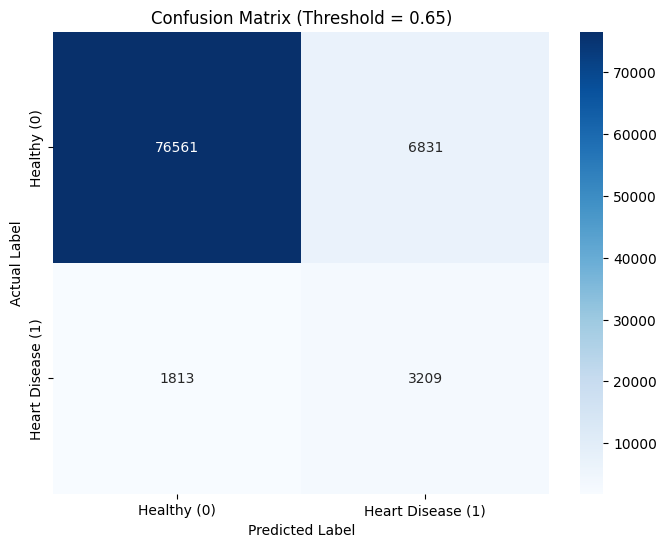

In [25]:


y_pred_proba = best_model.predict_proba(X_valid_selected)[:, 1]

roc = roc_auc_score(y_valid, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"ROC-AUC Score: {roc:.4f}")
print(f"PR-AUC Score: {pr_auc:.4f}")

f2_scores = [fbeta_score(y_valid, (y_pred_proba >= t).astype(int), beta=2) for t in thresholds]
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
best_f2 = f2_scores[best_idx]

print(f"\nBest threshold: {best_threshold:.4f}")
print(f" F2-Score: {best_f2:.4f}")


y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
print(classification_report(y_valid, y_pred_optimal))

cm = confusion_matrix(y_valid, y_pred_optimal)
labels = ["Healthy (0)", "Heart Disease (1)"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


tn, fp, fn, tp = cm.ravel()
